In this project a dataset containing crime statistics in the San Francisco area from X to Y is analyzed with the goal of creating a model to predict the nature of a crime based only on its time and location. 

More information on the project and its dataset can be found here:
https://www.kaggle.com/c/sf-crime

In [2]:
%matplotlib inline

import sys, os
from datetime import datetime
import numpy as np
import pandas
import matplotlib.pyplot as plt
from scipy import stats, integrate
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as holidaysCalendar
from sklearn.neighbors import KNeighborsClassifier

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

pandas.options.display.max_columns = 200
pandas.options.display.max_rows = 200

In [3]:
# Globals
WRITE = False

# Define header (from sample submission)
header = ["ID", "ARSON", "ASSAULT", "BAD CHECKS", "BRIBERY", "BURGLARY",
          "DISORDERLY CONDUCT", "DRIVING UNDER THE INFLUENCE", "DRUG/NARCOTIC",
          "DRUNKENNESS", "EMBEZZLEMENT", "EXTORTION", "FAMILY OFFENSES",
          "FORGERY/COUNTERFEITING", "FRAUD", "GAMBLING", "KIDNAPPING", "LARCENY/THEFT",
          "LIQUOR LAWS", "LOITERING", "MISSING PERSON", "NON-CRIMINAL", "OTHER OFFENSES",
          "PORNOGRAPHY/OBSCENE MAT", "PROSTITUTION", "RECOVERED VEHICLE", "ROBBERY",
          "RUNAWAY", "SECONDARY CODES", "SEX OFFENSES FORCIBLE", "SEX OFFENSES NON FORCIBLE",
          "STOLEN PROPERTY", "SUICIDE", "SUSPICIOUS OCC", "TREA", "TRESPASS", "VANDALISM",
          "VEHICLE THEFT", "WARRANTS", "WEAPON LAWS"]

In [4]:
# Helper Functions

def PredictAndPrint(data, classifier, outputname):
    # Predict
    result = classifier.predict(data)

    # Output
    result = pandas.DataFrame(result)
    result = pandas.get_dummies(result, prefix='', prefix_sep='')
    
    # Add null categories to make kaggle happy
    result = result.T.reindex(header).T.fillna(0)
    result.to_csv(outputname, compression='gzip', chunksize=1000)
    
def DetermineTime(hour):
    ## Add early morning, morning, afternoon, early evening, evening, late evening
    ## 0500-0800, 0800-1100, 1100-1600, 1600-2100, 2100-0200, 0200-0500
    if hour <= 2:
        return "evening"
    elif hour <= 5:
        return "lateE"
    elif hour <= 8:
        return "earlyM"
    elif hour <= 11:
        return "morning"
    elif hour <= 16:
        return "afternoon"
    elif hour <= 21:
        return "earlyE"
    else:
        return "evening"

def DetermineLocationType(address):
    ##Add block or corner
    if "block" in address.lower():
        return "block"
    elif "/" in address:
        return "corner"
    return None

def DetermineDayTime(time):
    ##Add Day Time
    time = int(time)
    if time >= 7 and time <= 19:
        return True
    elif time < 7 or time >= 19:
        return False
    return None

def Normalize(X):
    minx = min(X)
    maxx = max(X)
    subx = max(X)-min(X)
    return X.apply(lambda x: (x-minx)/subx)

def DetermineBlockCol(datacol):
    return 10 * round(datacol, 1)
 
def DetermineBlockRow(datarow):
    return 100 * round(datarow, 1)
    
def DetermineBlock(data):
    return int(xrow) + int(yrow)

def DetermineUnemp(data, unemp_dict):
    return unemp_dict[str(data.year)][str(calendar.month_abbr[data.month])]

def GenerateCoordToZipMap(filename, dict, data, read, write):
    # Load coords
    coords = data[['X', 'Y']]
    
    # Create/load dict
    geo_dict = dict
    if read:
        # Load GeoDict from file
        with open(datafile, 'r') as file:
        geo_dict = json.load(file)
    
    # Generate mappings
    for coord in coords.iterrows():
        X = round(coord[1][1], 4)
        Y = round(coord[1][0], 4)
        xy = str(X) + ", " + str(Y)
        # Check if existing
        if xy in geo_dict.keys():
            print ("Found! " + str(geo_dict[xy]) + " X: " + str(X) + "  Y: " + str(Y))
        else:
            success = False
            while not success:
                try:
                    location = geolocator.reverse(xy)
                    zip = location.address.split(',')[-2].strip()
                    geo_dict[xy] = zip
                    print ("Added: " + str(zip) + "  X: " + str(X) + "  Y: " + str(Y))
                    success = True
                except:
                    time.sleep(5)
    if write:
        # Write GeoDict to file
        with open(filename, 'w') as file:
            file.write(json.dumps(geo_dict))
    
    return geo_dict

def CoordsToZip(geo_dict, X, Y)
    X = round(X, 4)
    Y = round(Y, 4)
    xy = str(X) + ", " + str(Y)
    if xy in geo_dict.keys():
        return geo_dict[xy]
    # Not found
    return "00000"

def DetermineHoliday(date, holidays):
    if date in holidays:
        return 1
    return 0


#### Load data

In [4]:
# Load data
df_train = pandas.read_csv("train.csv")
df_test = pandas.read_csv("test.csv")

# Drop duplicates
#df_train = df_train.drop_duplicates()
#df_test = df_test.drop_duplicates()

# Shuffle
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

#### Exploratory Data Analysis
##### Revelations:
- Add euclidean distance using X,Y
- Add different size 'plots' of land for X,Y (trimming)
- Add temperature, precipitation
- Add block or corner
- Add time of day, day of week, weekend, week of year, season of year, holiday
- Add early morning, morning, afternoon, early evening, evening, late evening
- - 0500-0800, 0800-1100, 1100-1600, 1600-2100, 2100-0200, 0200-0500
- Convert 'TREA' to 'TRESPASS'

##### Columns

In [5]:
print ("Exploring data, columns, and formats")
print ("\nColumns:")
# View all columns
print (df_train.columns)

Exploring data, columns, and formats

Columns:
Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')


##### Dates

In [6]:
# Explore 'Dates'
print ("\nDates:")
print (df_train['Dates'].head(3))
## Add time of day, day of week, weekend, week of year, season of year, holiday
## Add early morning, morning, afternoon, early evening, evening, late evening
## 0500-0800, 0800-1100, 1100-1600, 1600-2100, 2100-0200, 0200-0500


Dates:
0    2009-08-31 22:30:00
1    2007-07-24 00:01:00
2    2013-06-16 17:05:00
Name: Dates, dtype: object


##### Category

In [7]:
# Explore 'Category'
print ("\nCategory:")
print (df_train['Category'].head(3))
print (set(df_train['Category']))
## OUTCOME VARIABLE
## Possible issue with 'Trea' and 'Trespass'
## Convert 'TREA' to 'TRESPASS'
len(df_train[df_train['Category'] == 'TREA'])


Category:
0          ASSAULT
1    LARCENY/THEFT
2         WARRANTS
Name: Category, dtype: object
{'ARSON', 'SEX OFFENSES FORCIBLE', 'SEX OFFENSES NON FORCIBLE', 'TREA', 'BURGLARY', 'SUSPICIOUS OCC', 'VANDALISM', 'SUICIDE', 'DRIVING UNDER THE INFLUENCE', 'KIDNAPPING', 'EMBEZZLEMENT', 'FORGERY/COUNTERFEITING', 'EXTORTION', 'LARCENY/THEFT', 'NON-CRIMINAL', 'SECONDARY CODES', 'PROSTITUTION', 'DRUG/NARCOTIC', 'WEAPON LAWS', 'OTHER OFFENSES', 'LOITERING', 'RUNAWAY', 'STOLEN PROPERTY', 'BAD CHECKS', 'LIQUOR LAWS', 'MISSING PERSON', 'DISORDERLY CONDUCT', 'TRESPASS', 'RECOVERED VEHICLE', 'VEHICLE THEFT', 'ASSAULT', 'FRAUD', 'DRUNKENNESS', 'GAMBLING', 'ROBBERY', 'BRIBERY', 'WARRANTS', 'PORNOGRAPHY/OBSCENE MAT', 'FAMILY OFFENSES'}


6

##### Descript

In [8]:
# Explore 'Descript'
print ("\nDescript:")
print (df_train['Descript'].head(3))
## NOT IN TEST DATA
## Does not appear to be useful


Descript:
0    AGGRAVATED ASSAULT WITH A GUN
1     GRAND THEFT FROM LOCKED AUTO
2                   WARRANT ARREST
Name: Descript, dtype: object


##### DayOfWeek

In [9]:
# Explore 'DayOfWeek'
print ("\nDayOfWeek:")
print (df_train['DayOfWeek'].head(3))
print (set(df_train['DayOfWeek']))
total = 0
for x in set(df_train['DayOfWeek']):
    total += len(df_train[df_train['DayOfWeek'] == x])
print ("Missing values in DayOfWeek: " + str(len(df_train) - total))
## Looks good


DayOfWeek:
0     Monday
1    Tuesday
2     Sunday
Name: DayOfWeek, dtype: object
{'Tuesday', 'Wednesday', 'Saturday', 'Sunday', 'Monday', 'Thursday', 'Friday'}
Missing values in DayOfWeek: 0


##### PdDistrict

In [10]:
# Explore 'PdDistrict'
print ("\nPdDistrict:")
print (df_train['PdDistrict'].head(3))
print (set(df_train['PdDistrict']))
total = 0
for x in set(df_train['PdDistrict']):
    total += len(df_train[df_train['PdDistrict'] == x])
print ("Missing values in PdDistrict: " + str(len(df_train) - total))
## Looks good


PdDistrict:
0     BAYVIEW
1    NORTHERN
2        PARK
Name: PdDistrict, dtype: object
{'RICHMOND', 'SOUTHERN', 'NORTHERN', 'CENTRAL', 'TENDERLOIN', 'TARAVAL', 'PARK', 'INGLESIDE', 'MISSION', 'BAYVIEW'}
Missing values in PdDistrict: 0


##### Resolution

In [11]:
# Explore 'Resolution'
print ("\nResolution:")
print (df_train['Resolution'].head(3))
## NOT IN TEST DATA
## Does not appear to be useful


Resolution:
0              NONE
1              NONE
2    ARREST, BOOKED
Name: Resolution, dtype: object


##### Address

In [12]:
# Explore 'Address'
print ("\nAddress:")
print (df_train['Address'].head(3))
## Count Blocks, Corners
blocks = corners = neither = 0
for address in df_train['Address']:
    if "block" in address.lower():
        blocks += 1
    elif "/" in address:
        corners += 1
    else:
        neither += 1
print ("Number of blocks: " + str(blocks))
print ("Number of corners: " + str(corners))
print ("Number of neither: " + str(neither))
print ("Number of both: " + str(blocks + corners - (len(df_train) - neither)))

## Add block or corner


Address:
0          3RD ST / EVANS AV
1       OAK ST / FILLMORE ST
2    700 Block of STANYAN ST
Name: Address, dtype: object
Number of blocks: 617231
Number of corners: 260818
Number of neither: 0
Number of both: 0


##### 'X' and 'Y'


X and Y:
Empty X coords :0
Empty Y coords :0
Distinct X coords :34243
Distinct Y coords :34243


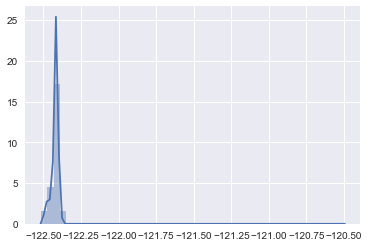

In [13]:
# Explore 'X' and 'Y'
print ("\nX and Y:")
print ("Empty X coords :" + str(len(df_train[df_train['X'] == 0])))
print ("Empty Y coords :" + str(len(df_train[df_train['Y'] == 0])))
print ("Distinct X coords :" + str(len(set(df_train['X']))))
print ("Distinct Y coords :" + str(len(set(df_train['Y']))))

sns.set(color_codes=True)
# Verify integrity of coordinates
#sns.distplot(list(df_train['Y']))
sns.distplot(list(df_train['X']))

df_train = df_train[df_train['Y'] < 38]
df_train = df_train[df_train['X'] != -120.5]
df_test = df_test[df_test['Y'] < 38]
df_test = df_test[df_test['X'] != -120.5]

#### Feature Engineering
- Add euclidean distance using X,Y
- Add different size 'plots' of land for X,Y using 10x10 grid
- Add temperature, precipitation
- Add block or corner
- Add time of day, week of year, season of year, holiday, sun up or down
- Add early morning, morning, afternoon, early evening, evening, late evening
- - 0500-0800, 0800-1100, 1100-1600, 1600-2100, 2100-0200, 0200-0500
- Convert 'TREA' to 'TRESPASS'

In [14]:
# Binarize with dummy variables
#dummies_df_train = df_train[['DayOfWeek', 'PdDistrict']]
#dummies_df_train = pandas.get_dummies(dummies_df_train)
#dummies_df_test = df_test[['DayOfWeek', 'PdDistrict']]
#dummies_df_test = pandas.get_dummies(dummies_df_test)

# Format Dates
## Hour of day
df_train['Hour'] = pandas.to_datetime(df_train['Dates']).dt.hour
df_test['Hour'] = pandas.to_datetime(df_test['Dates']).dt.hour

## Time of day
df_train['Time'] = df_train['Hour'].apply(lambda x: DetermineTime(x))
df_test['Time'] = df_test['Hour'].apply(lambda x: DetermineTime(x))

## Day
df_train['DayTime'] = df_train['Hour'].apply(lambda x: DetermineDayTime(x))
df_test['DayTime'] = df_test['Hour'].apply(lambda x: DetermineDayTime(x))

## Week of year
df_train['Week'] = pandas.to_datetime(df_train['Dates']).dt.week
df_test['Week'] = pandas.to_datetime(df_test['Dates']).dt.week

## Season of year
#df_train['Season'] = pandas.to_datetime(df_train['Dates']).dt.week
#df_test['Season'] = pandas.to_datetime(df_test['Dates']).dt.week

## Reduce to date
df_train['Date'] = pandas.to_datetime(df_train['Dates']).dt.date
df_test['Date'] = pandas.to_datetime(df_test['Dates']).dt.date

# Adjust out of bounds values
df_train[df_train['Y'] < 38] = np.median(df_train['Y'])
df_train[df_train['X'] != -120.5] = np.median(df_train['X'])
df_test[df_test['Y'] < 38] = np.median(df_test['Y'])
df_test[df_test['X'] != -120.5] = np.median(df_test['X'])

## Holidays
cal = holidaysCalendar()
holidays = cal.holidays(start=pandas.to_datetime(df_train['Date']).min(), end=pandas.to_datetime(df_train['Date']).max())

# Not comparing correctly, writing this manually
holiday_list = []
for day in holidays:
    holiday_list.append(str(day).split(' ')[0])
hol_str = str(holiday_list)
df_train['Holiday'] = df_train['Date'].apply(lambda x: DetermineHoliday(str(x), hol_str))

# Format Address
## Add address type
df_train['LocationType'] = df_train['Address'].apply(lambda x: DetermineLocationType(x))
df_test['LocationType'] = df_test['Address'].apply(lambda x: DetermineLocationType(x))

## Form BlockID
df_train['X'] = Normalize(df_train['X'])
df_train['Y'] = Normalize(df_train['Y'])
blockRow = df_train['X'].apply(lambda x: DetermineBlockRow(x))
blockCol = df_train['Y'].apply(lambda x: DetermineBlockCol(x))
df_train['BlockID'] = blockRow + blockCol
df_train = df_train[df_train['BlockID'] != 89]

df_test['X'] = Normalize(df_test['X'])
df_test['Y'] = Normalize(df_test['Y'])
blockRow = df_test['X'].apply(lambda x: DetermineBlockRow(x))
blockCol = df_test['Y'].apply(lambda x: DetermineBlockCol(x))
df_test['BlockID'] = blockRow + blockCol
# Clean
del blockRow, blockCol

# Add Temperature

# More dates
df_train['Month'] = df_train['Date'].apply(lambda x: x.month)
df_train['Day'] = df_train['Date'].apply(lambda x: x.day)
df_train['Year'] = df_train['Date'].apply(lambda x: x.year)

# Add Unemployment
## Unemployment data
## Load from csv
unemp = pandas.read_csv("cal_unemployment.csv")
unemp = unemp[['Label', 'Value']]
## Load into dict
unemp_dict = {}
for i in range(len(unemp)):
    year = unemp['Label'][i].split(' ')
    month = year[1]
    year = year[0]
    if year in unemp_dict.keys():
        unemp_dict[year][month] = unemp['Value'][i]
    else:
        unemp_dict[year] = {}
        unemp_dict[year][month] = unemp['Value'][i]
## Add column
df_train['Unemp'] = df_train['Date'].apply(lambda x: DetermineUnemp(x, unemp_dct))
df_train['Unemp'] = Normalize(df_train['Unemp'])

# Add Zip code
geolocator = Nominatim()
geo_dict = {}
coords = df_train[['X', 'Y']]
    
df_train['Zip'] = df_train[['X','Y']].apply(lambda row: CoordsToZip(geo_dict, df_train['X'], df_train['Y']), axis=1)

In [15]:
# Drop unnecessary columns
df_train = df_train.drop(['Date', 'Dates', 'Address', 'Resolution', 'Descript'],axis=1)
df_test = df_test.drop(['Date', 'Dates', 'Address', 'Id'],axis=1)

# Name
train_data = df_train
test_data = df_test

# Clean
del df_train, df_test

#### Encoding

In [16]:
# Encode time
train_data = train_data.join(pandas.get_dummies(train_data['Time'])).drop('Time', axis=1)
test_data = test_data.join(pandas.get_dummies(test_data['Time'])).drop('Time', axis=1)

# Encode LocationType
train_data = train_data.join(pandas.get_dummies(train_data['LocationType'])).drop('LocationType', axis=1)
test_data = test_data.join(pandas.get_dummies(test_data['LocationType'])).drop('LocationType', axis=1)

# Encode PdDistrict
train_data = train_data.join(pandas.get_dummies(train_data['PdDistrict'])).drop('PdDistrict', axis=1)
test_data = test_data.join(pandas.get_dummies(test_data['PdDistrict'])).drop('PdDistrict', axis=1) 

# Encode DayOfWeek
train_data = train_data.join(pandas.get_dummies(train_data['DayOfWeek'])).drop('DayOfWeek', axis=1)
test_data = test_data.join(pandas.get_dummies(test_data['DayOfWeek'])).drop('DayOfWeek', axis=1)

# Encode BlockID
train_data = train_data.join(pandas.get_dummies(train_data['BlockID'])).drop('BlockID', axis=1)
test_data = test_data.join(pandas.get_dummies(test_data['BlockID'])).drop('BlockID', axis=1)
train_data = train_data.drop('X', axis=1)
train_data = train_data.drop('Y', axis=1)
test_data = test_data.drop('X', axis=1)
test_data = test_data.drop('Y', axis=1)

In [17]:
# Label Encoding
le = preprocessing.LabelEncoder()
for column in train_data.columns:
    if train_data[column].dtype == type(object):
        train_data[column] = le.fit_transform(train_data[column])
for column in test_data.columns:
    if test_data[column].dtype == type(object):
        test_data[column] = le.fit_transform(test_data[column])

In [18]:
# Split into data/labels, train/dev
train_labels = train_data['Category'][:-50000]
dev_labels = train_data['Category'][-50000:]

train_data = train_data[train_data.columns.difference(['Category'])][:-50000]
dev_data = train_data[train_data.columns.difference(['Category'])][-50000:]


# Labels list
labels = list(set(train_labels))
train_labels = train_labels.apply(lambda x: labels.index(x))
dev_labels = dev_labels.apply(lambda x: labels.index(x))

### Baseline Model
##### K-Nearest Neighbor with k=50

Need to add GridSearchCV here

In [ ]:

#parameters = {'n_neighbors': range(5,50, 5)}

#neigh = GridSearchCV(KNeighborsClassifier(), parameters)
#neigh.fit(train_data, train_labels)
#print (sorted(neigh.cv_results_.keys()))

# Train KNN Classifier
neigh = KNeighborsClassifier(n_neighbors=500)

# Fit
neigh.fit(train_data, train_labels) 

# Score
print (neigh.score(dev_data, dev_labels))

#if WRITE:
#    PredictAndPrint(test_data, neigh, "output_knn")


### Logistic Regression
##### Final Parameters:

In [ ]:
sns.set(color_codes=True)
# Verify integrity of coordinates
#sns.distplot(list(df_train['Y']))
sns.distplot(list(test_data['X']))

### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=100,
    learning_rate=1)

adab.fit(train_data, train_labels)

adab.score(dev_data, dev_labels)


### Support Vector Machines
##### Final Parameters:

In [ ]:
from sklearn import svm

svm_clf = svm.SVC(decision_function_shape='ovo')

svm_clf.fit(train_data, train_labels)

svm_clf.score(dev_data, dev_labels)


### Random Forests
##### Final Parameters:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#parameters = {'n_estimators': range(10,50, 10), 'min_samples_split': range(2,5, 1)}
#rfc = GridSearchCV(RandomForestClassifier(), parameters)
#rfc.fit(train_data, train_labels)
#print (sorted(rfc.cv_results_.keys()))

# Train RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=11, max_depth=None, min_samples_split=10, random_state=0)

# Fit
rfc.fit(train_data, train_labels)

# Score
print (rfc.score(dev_data, dev_labels))

### Neural-Network
##### Final Parameters:

In [19]:
numFeatures = len(train_data.columns)
numClasses = len(labels)
numSamples = len(train_data)
numTestExamples = len(dev_data)

print (numFeatures)
print (numClasses)
print (numSamples)
print (numTestExamples)

120
39
827826
50000


#### Sequential

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, ActivityRegularization
from keras.layers import Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers

# Define
sequential_model = Sequential()
sequential_model.add(Dense(units=numFeatures * 2, activation='hard_sigmoid', input_shape=(numFeatures,)))
sequential_model.add(Dense(units=int(numFeatures), activation='softmax' ))
#sequential_model.add(Dropout(0.05, noise_shape=None, seed=None))

# Compile
sequential_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adamax',
              metrics=['accuracy'])
# Fit
sequential_model.fit(train_data.values, train_labels.values, epochs=20, batch_size=100)

Using TensorFlow backend.


Epoch 1/20
827826/827826 [==============================] - 82s 99us/step - loss: 2.5402 - acc: 0.2348
Epoch 2/20
827826/827826 [==============================] - 82s 99us/step - loss: 2.5086 - acc: 0.2397
Epoch 3/20
827826/827826 [==============================] - 80s 97us/step - loss: 2.5008 - acc: 0.2413
Epoch 4/20
827826/827826 [==============================] - 80s 97us/step - loss: 2.4947 - acc: 0.2428
Epoch 5/20
827826/827826 [==============================] - 79s 96us/step - loss: 2.4905 - acc: 0.2440
Epoch 6/20
827826/827826 [==============================] - 80s 97us/step - loss: 2.4871 - acc: 0.2440
Epoch 7/20
827826/827826 [==============================] - 91s 110us/step - loss: 2.4842 - acc: 0.2449
Epoch 8/20
827826/827826 [==============================] - 89s 107us/step - loss: 2.4821 - acc: 0.2457
Epoch 9/20
827826/827826 [==============================] - 90s 109us/step - loss: 2.4799 - acc: 0.2457
Epoch 10/20
827826/827826 [==============================] - 85s 103us

In [21]:
# Define
sequential_model = Sequential()
sequential_model.add(Dense(units=numFeatures * 2, activation='hard_sigmoid', input_shape=(numFeatures,)))
sequential_model.add(Dense(units=int(numFeatures), activation='softmax' ))
#sequential_model.add(Dropout(0.05, noise_shape=None, seed=None))

# Compile
sequential_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Nadam',
              metrics=['accuracy'])
# Fit
sequential_model.fit(train_data.values, train_labels.values, epochs=20, batch_size=100)

Epoch 1/20
827826/827826 [==============================] - 90s 108us/step - loss: 2.5260 - acc: 0.2374
Epoch 2/20
827826/827826 [==============================] - 90s 108us/step - loss: 2.4954 - acc: 0.2429
Epoch 3/20
827826/827826 [==============================] - 86s 104us/step - loss: 2.4873 - acc: 0.2443
Epoch 4/20
827826/827826 [==============================] - 93s 112us/step - loss: 2.4825 - acc: 0.2456
Epoch 5/20
827826/827826 [==============================] - 92s 111us/step - loss: 2.4795 - acc: 0.2461
Epoch 6/20
827826/827826 [==============================] - 90s 109us/step - loss: 2.4768 - acc: 0.2469
Epoch 7/20
827826/827826 [==============================] - 90s 109us/step - loss: 2.4747 - acc: 0.2471
Epoch 8/20
827826/827826 [==============================] - 90s 108us/step - loss: 2.4729 - acc: 0.2476
Epoch 9/20
827826/827826 [==============================] - 91s 110us/step - loss: 2.4712 - acc: 0.2482
Epoch 10/20
827826/827826 [==============================] - 89s

In [ ]:
# Define
sequential_model = Sequential()
sequential_model.add(Dense(units=numFeatures * 2, activation='tanh', input_shape=(numFeatures,)))
sequential_model.add(Dense(units=int(numFeatures), activation='softmax' ))
#sequential_model.add(Dropout(0.05, noise_shape=None, seed=None))

# Compile
sequential_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Nadam',
              metrics=['accuracy'])
# Fit
sequential_model.fit(train_data.values, train_labels.values, epochs=20, batch_size=100)

In [28]:
# Define
sequential_model = Sequential()
sequential_model.add(Dense(units=numFeatures * 2, activation='hard_sigmoid', input_shape=(numFeatures,)))
sequential_model.add(Dense(units=int(numFeatures), activation='softmax' ))
#sequential_model.add(Dropout(0.05, noise_shape=None, seed=None))

# Compile
sequential_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Nadam',
              metrics=['accuracy'])
# Fit
sequential_model.fit(train_data.values, train_labels.values, epochs=20, batch_size=50)

Epoch 1/20
827826/827826 [==============================] - 118s 143us/step - loss: 2.5226 - acc: 0.2375
Epoch 2/20
827826/827826 [==============================] - 113s 137us/step - loss: 2.4942 - acc: 0.2430
Epoch 3/20
827826/827826 [==============================] - 102s 123us/step - loss: 2.4877 - acc: 0.2442
Epoch 4/20
827826/827826 [==============================] - 105s 127us/step - loss: 2.4841 - acc: 0.2453
Epoch 5/20
827826/827826 [==============================] - 116s 140us/step - loss: 2.4815 - acc: 0.2457
Epoch 6/20
827826/827826 [==============================] - 117s 141us/step - loss: 2.4802 - acc: 0.2460
Epoch 7/20
827826/827826 [==============================] - 116s 141us/step - loss: 2.4790 - acc: 0.2466
Epoch 8/20
827826/827826 [==============================] - 116s 140us/step - loss: 2.4781 - acc: 0.2462
Epoch 9/20
827826/827826 [==============================] - 113s 136us/step - loss: 2.4773 - acc: 0.2468
Epoch 10/20
827826/827826 [============================

In [ ]:
# Score
#print (sequential_model.evaluate(dev_data.values, dev_labels.values, batch_size=100))

# Predict
keras_seq_result = sequential_model.predict(test_data.values, batch_size=100)
#print (keras_seq_result)
# Output
keras_seq_result = pandas.DataFrame(keras_seq_result)
print (keras_seq_resul.head())
keras_seq_result = pandas.get_dummies(keras_seq_result, prefix='', prefix_sep='')
print (keras_seq_result.head())
# Add null categories to make kaggle happy
keras_seq_result = keras_seq_result.T.reindex(header).T.fillna(0)
keras_seq_result.to_csv("output_keras_seq.csv", compression='gzip', chunksize=1000)
       
print (max(keras_seq_result[0]))
print (np.argwhere(keras_seq_result[0] == max(keras_seq_result[0])))

In [ ]:
# Define ## 2.45
sequential_model = Sequential()
sequential_model.add(Dense(units=numFeatures * 2, activation='hard_sigmoid', input_shape=(numFeatures,)))
sequential_model.add(Dense(units=int(numFeatures), activation='softmax' ))
#sequential_model.add(Dropout(0.05, noise_shape=None, seed=None))

# Compile
sequential_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Nadam',
              metrics=['accuracy'])
# Fit
sequential_model.fit(train_data.values, train_labels.values, epochs=20, batch_size=100)

In [ ]:
# (1) Parameters
tf.reset_default_graph()

# Constants
testX = tf.constant(dev_data.values, dtype=tf.float32)
hiddenlayer1_size = 2
hiddenlayer2_size = 1
miniBatchSize = 1

# placeholders
x_ = tf.placeholder(tf.float32, shape=[None, numFeatures], name='x')
y_ = tf.placeholder(tf.int32, shape=[None], name='y')

# and Variables
w1 = tf.get_variable('w1', shape=[numFeatures, hiddenlayer1_size])
b1 = tf.get_variable('b1', shape=[hiddenlayer1_size])
w2 = tf.get_variable('w2', shape=[hiddenlayer1_size, numClasses])
b2 = tf.get_variable('b2', shape=[numClasses])


# (2) Model
def model(input_layer):
    hidden_layer1 = tf.nn.sigmoid(tf.matmul(input_layer, w1) + b1)
    output_layer = tf.nn.softmax(tf.matmul(hidden_layer1, w2) + b2)
    return output_layer

# (2) Model
def model_r(input_layer):
    hidden_layer1 = tf.nn.relu(tf.matmul(input_layer, w1) + b1)
    output_layer = tf.nn.softmax(tf.matmul(hidden_layer1, w2) + b2)
    return output_layer
    

# (3) Cost
def cost(data, labels):
    cc = tf.sqrt(tf.square(labels - model(data)))
    return  cc

# (4) Ojbective (and solver)
y_one_hot = tf.one_hot(y_, numClasses)
cc = cost(x_, y_one_hot)
gd = tf.train.GradientDescentOptimizer(0.1)
step = gd.minimize(cc)
test_preds = model(testX)
test_preds_r = model_r(testX)
output = ""
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost_vec = []
    cost_vec_r = []
    for i in range(15):
        print (i)
        for start, end in zip(range(0, numSamples, miniBatchSize), range(miniBatchSize, numSamples, miniBatchSize)):
            batch = train_data.values[start:end], train_labels[start:end]
            _, cost, test__preds_r = sess.run([step, cc, test_preds_r], feed_dict={x_: batch[0], y_: batch[1]})
    
    prediction=tf.argmax(test_preds_r,axis=1)
    output = prediction.eval(feed_dict={x_: test_data.values})
    print ("hi")

In [ ]:
from sklearn.ensemble import VotingClassifier
# Initial ensemble
voting_clf = VotingClassifier(estimators=[
         ('knn', knn), ('adab', adab), ('keras_nn', smnn)], voting='hard', weights=[.75,.75,1])
# Fit
voting_clf = voting_clf.fit(train_data.values, train_labels.values)
# Predict, print
PredictAndPrint(test_data, voting_clf, "voting_clf_1")